#### Import sympy - pythons symbol library

# Sensitivity analysis in Python
A helper for TEP4285 at NTNU - by Nils Dittrich, 2023

In [42]:
import sympy as sy
# for later representation of the results:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Example system
You can apply all methods (and even most of the code) from this notebook to any new system, here the example we will demonstrate this on:
![Alt text](image.png)

#### Define your model parameters as sympy symbols

In [43]:
P = sy.Symbol('P')
SP_osl = sy.Symbol('SP_osl')
CW = sy.Symbol('CW')
K_34C = sy.Symbol('K_34C')
Ltc = sy.Symbol('Ltc')
APC = sy.Symbol('APC')
M_CO2 = sy.Symbol('M_CO2')
M_Al = sy.Symbol('M_Al')
M_C = sy.Symbol('M_C')
RC1 = sy.Symbol('RC1')
Al_an = sy.Symbol('Al_an')
C_an = sy.Symbol('C_an')
C_cat = sy.Symbol('C_cat')
Al_cat = sy.Symbol('Al_cat')
all_paras = [P, SP_osl, CW, K_34C, Ltc, APC, M_CO2, M_Al, M_C, RC1, Al_an, C_an, C_cat, Al_cat]


#### Store the values of each parameter in a dict (keyed to the parameter)
The cell above defines the parameters as symbols, but for calculating sensitivities or evaluating the flow itself we also need to store the values for each parameter - we do so in a dictionary.

In [44]:
actual_values = {
        P : 407, 
        SP_osl : 1/3, 
        CW : 0.0007, 
        K_34C : 0.5, 
        Ltc : 5, 
        APC : 0.004, 
        M_CO2 : 44.01, 
        M_Al : 27, 
        M_C : 12, 
        RC1 : 0.5, 
        Al_an : 0.1, 
        C_an : 0.9, 
        C_cat : 0.4535, 
        Al_cat : 0.093

    }

#### Define the solution for the flow you want to analyze
Just add your (pythonic) analytical solution for the flow in the first subfunction.
This function is then used to set up the partial derivatives neeeded for the sensitivity analysis.

In [67]:
def AXX(*all_paras):
    A_40_CO2 =  ((P * SP_osl * (1+(CW * K_34C * Al_cat)/(Ltc * APC * C_cat)) * 3/4 * M_CO2 / M_Al)) / (1-(RC1 * Al_an / C_an * 3/4 * (M_C / M_Al) * (1 / (1-RC1))))
    # *all_paras unwraps all the parameterse into the function,
    # so you can use them for your function here.
    return A_40_CO2
    

def sensitivity_A_40_CO2(para):
    # first we differentiate with respect to para
    def AXX_dif(AXX, *all_paras):
        '''differentiates AXX'''
        return sy.diff(AXX(*all_paras), para)
    
    # evaluate...
    NoP_A_40_CO2 = AXX(*all_paras).subs(actual_values)
    abs_sens = AXX_dif(AXX, *all_paras).subs(actual_values)
    rel_sens = abs_sens*actual_values[para]/NoP_A_40_CO2
    return abs_sens, rel_sens
    
NoP_A_40_CO2 = AXX(*all_paras).subs(actual_values)
print(f'the absolute value of A_40_CO2 is {np.round(float(NoP_A_40_CO2),2)} kt')
sensitivities_A_40_CO2 = {}
for para in all_paras:
    abs_sens, rel_sens = sensitivity_A_40_CO2(para)
    # store the sensitivities in a dict
    sensitivities_A_40_CO2[para.__str__()] = float(rel_sens)
    # also just print them
    print(f'The sensitivity of flow A_40_CO2 on  parameter {para} is {np.round(float(abs_sens), 4)}'\
          f'in absolute terms, and the relative one {np.round(float(rel_sens), 4)}.')

the absolute value of A_40_CO2 is 172.85 kt
The sensitivity of flow A_40_CO2 on  parameter P is 0.4247in absolute terms, and the relative one 1.0.
The sensitivity of flow A_40_CO2 on  parameter SP_osl is 518.5486in absolute terms, and the relative one 1.0.
The sensitivity of flow A_40_CO2 on  parameter CW is 882.9947in absolute terms, and the relative one 0.0036.
The sensitivity of flow A_40_CO2 on  parameter K_34C is 1.2362in absolute terms, and the relative one 0.0036.
The sensitivity of flow A_40_CO2 on  parameter Ltc is -0.1236in absolute terms, and the relative one -0.0036.
The sensitivity of flow A_40_CO2 on  parameter APC is -154.5241in absolute terms, and the relative one -0.0036.
The sensitivity of flow A_40_CO2 on  parameter M_CO2 is 3.9275in absolute terms, and the relative one 1.0.
The sensitivity of flow A_40_CO2 on  parameter M_Al is -6.6481in absolute terms, and the relative one -1.0385.
The sensitivity of flow A_40_CO2 on  parameter M_C is 0.554in absolute terms, and th

#### Visualize and interpretate your results
This is an extremely important step, even in simple results like the ones we produced for this sensitivity analysis. We print a heatstrip of the sensitivies to make a visual comparison easier (this makes more sense when dealing with more dimensions of sensitivies, and could in this case be replaced by e.g. a bar chart.). Other modes of visualization are very welcome.

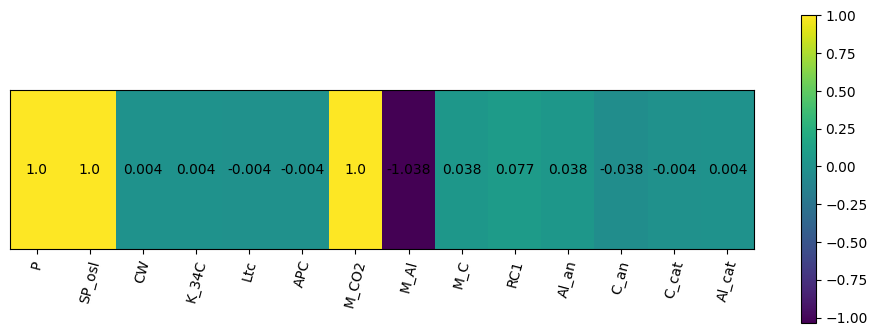

In [ ]:
sens = list(sensitivities_A40.values())
sensitivites = np.array( [sens, sens, sens])
fig, ax = plt.subplots(figsize = (12, 4))
plt.imshow(sensitivites, cmap='viridis', interpolation='nearest')
ax.set_xticks(np.arange(len(all_paras)))
ax.set_xticklabels([para.__str__() for para in all_paras], rotation = 75)
plt.colorbar()
ax.set(yticklabels=[])
ax.tick_params(left=False)
for i,para in enumerate(all_paras):
    text = ax.text(i, 1, np.round(sens[i],3), ha="center", va="center", color="k")


#### Investigating the impact of individual parameters
The main point of conducting a sensitivity analysis is to screen the parameter space for candidates for particularly strong effects on a result. We can (and should) then do a further investigation of how this parameter influences the results at different values and operating points.

The function below can be used as a simple starting point, where we do an one-at-a-time variation of a parameter on our flow defined above, and then visualize the results.

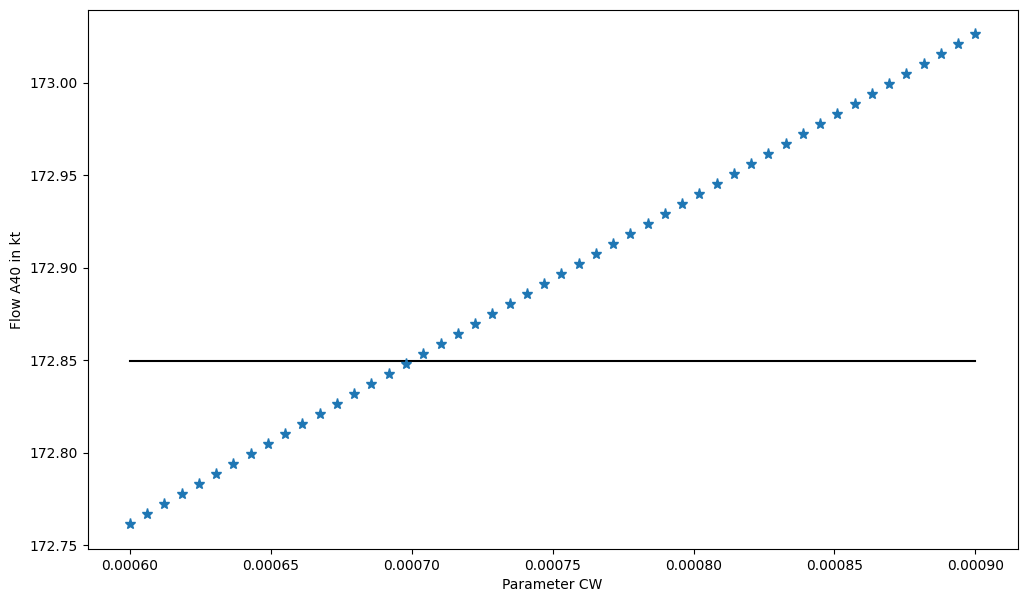

In [ ]:
def OFAT_variation(para, start:float, stop:float):
    flow_values = []
    oj_value = actual_values[para]
    para_values = np.linspace(start, stop, 50)
    for value in para_values:
        actual_values[para] = value
        flow_values.append(AXX(*all_paras).subs(actual_values))
    # reset the actual value so we don't influence any later analysis
    actual_values[para] = oj_value
    plt.figure(figsize=(12,7))
    plt.plot([para_values[0], para_values[-1]], [NoP_A01, NoP_A01], c = 'k', label = 'NOP')
    plt.plot(para_values, flow_values, '*', ms = 8, label = f'A40 - varying {para}')
    plt.ylabel('Flow A40 in kt')
    plt.xlabel(f'Parameter {para.__str__()}')
    plt.show()

OFAT_variation(CW, 600/10**6, 900/10**6)



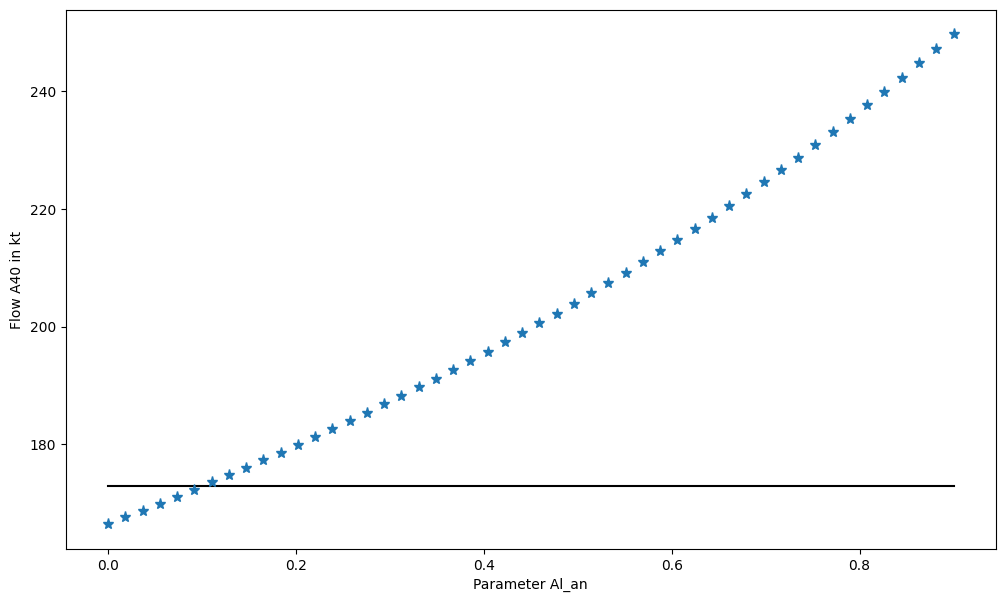

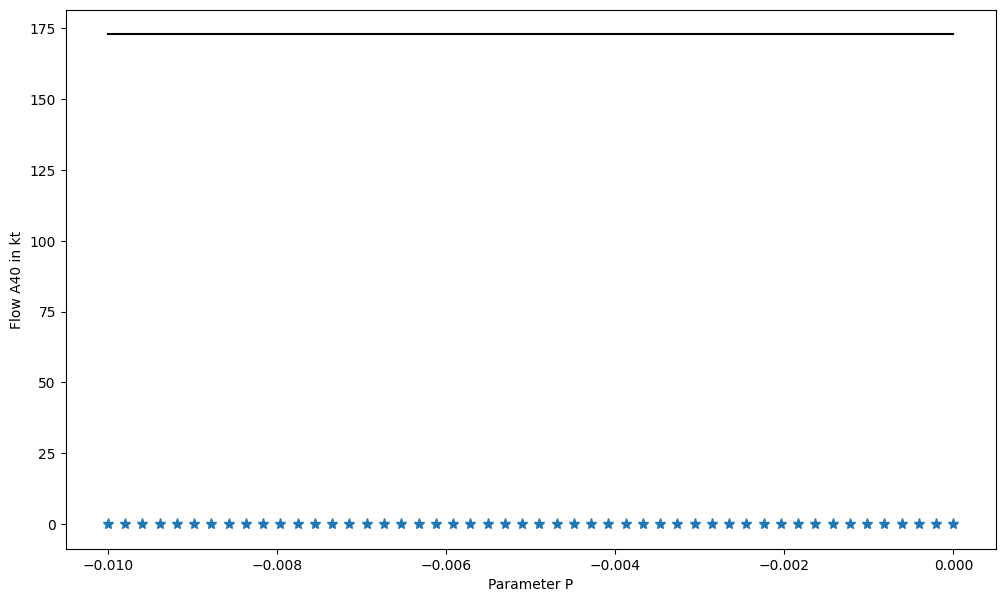

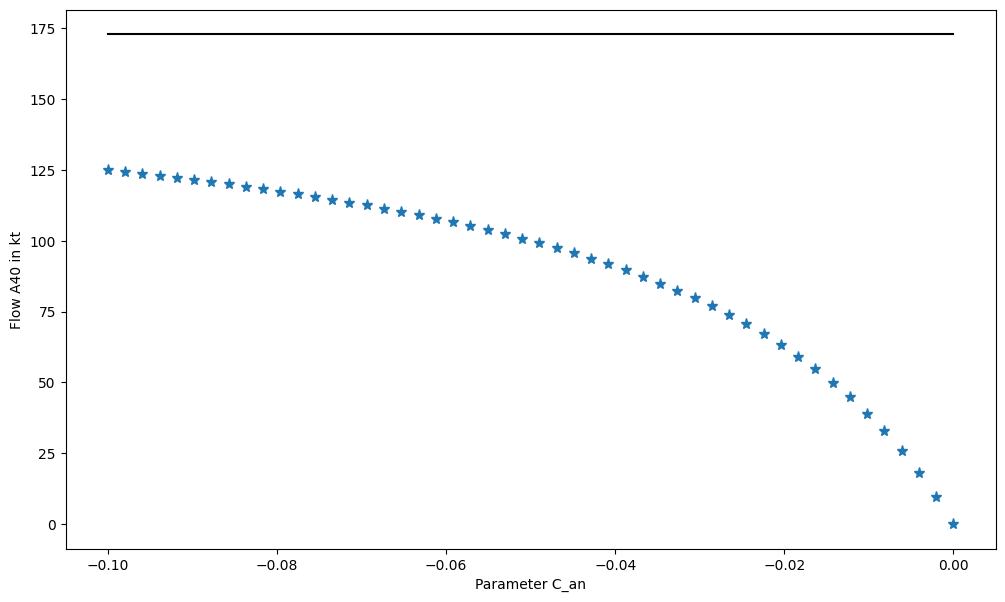

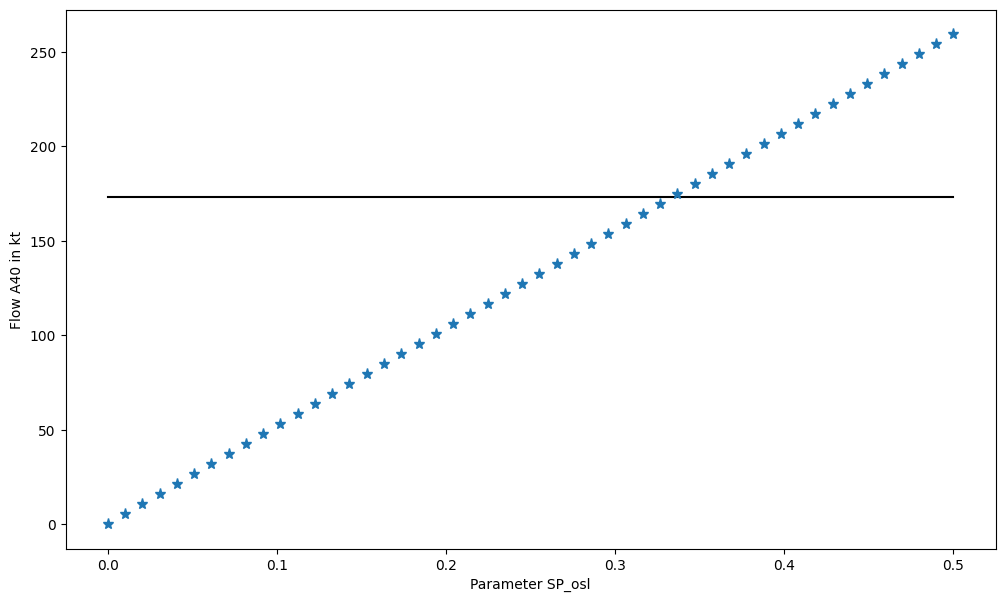

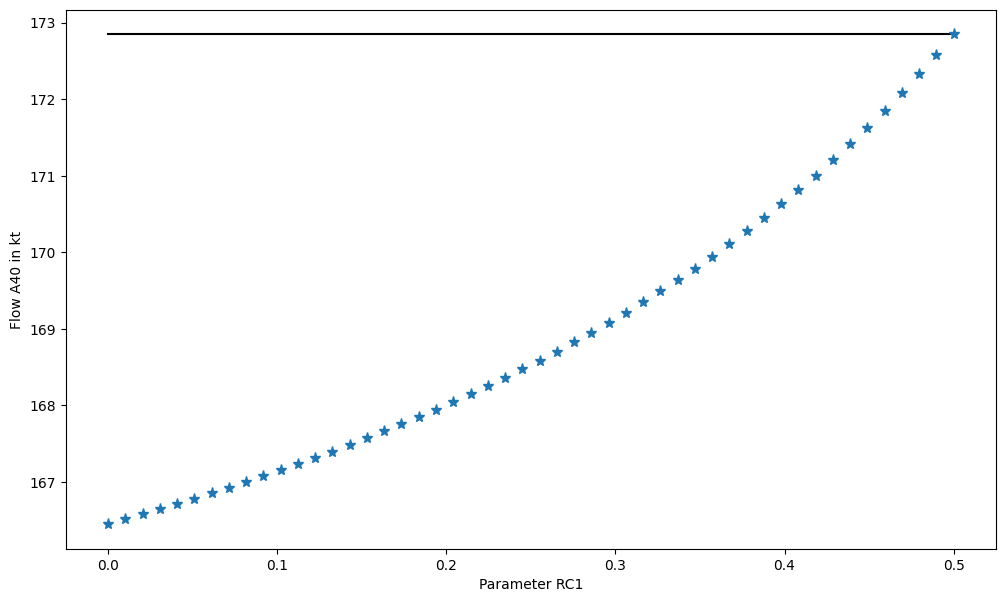

In [ ]:
OFAT_variation(Al_an, 0, 0.9)
OFAT_variation(P, 0, -0.01)
OFAT_variation(C_an, 0, -0.1)
OFAT_variation(SP_osl, 0, 0.5)
OFAT_variation(RC1, 0, 0.5)

#### Saving results
Save however you want, but it might be convenient to get the sensitivites into an excel.

In [ ]:
sens_df = pd.DataFrame([sensitivities_A40])
print(sens_df)
sens_df.to_excel('sensitivites.xlsx')


     P  SP_osl        CW     K_34C       Ltc       APC  M_CO2      M_Al  \
0  1.0     1.0  0.003576  0.003576 -0.003576 -0.003576    1.0 -1.038462   

        M_C       RC1     Al_an      C_an     C_cat    Al_cat  
0  0.038462  0.076923  0.038462 -0.038462 -0.003576  0.003576  


ModuleNotFoundError: No module named 'openpyxl'

: 